In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np # for array processing
import pandas as pd 

from scipy.stats import norm
from scipy import stats
from scipy.stats import gaussian_kde

import datetime

#import folium
from IPython.display import HTML
from IPython.display import IFrame
import base64

from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.tools.eval_measures import rmse

from itertools import cycle, islice
#from mpld3 import save_html  #Installed from conda
#from folium import IFrame
#from mpl_toolkits.basemap import Basemap

In [2]:
from platform import python_version
#mport statsmodels.api as sm
#rint(sm.version())
print(python_version())
print(pd.__version__)

3.8.5
1.1.3


### Read in the Growth data. You need to choose if you read it all in or the file with some removed

In [3]:
df=pd.read_excel('DataFiles/tree_census_join_20210613.xlsx')  # updated with side of road

In [4]:
df['growth_rate']=df['growth']/10
print(df['growth_rate'].describe())

count    126362.000000
mean          0.275303
std           0.233739
min          -0.500000
25%           0.100000
50%           0.300000
75%           0.400000
max           1.600000
Name: growth_rate, dtype: float64


### Outliers
I turn the largest buildings and the most populated census tract into nan.  They were far outliers of BuiltFAR>200 and pop_density>500,000

In [5]:
#df=df[df.BuiltFAR<200]
#print('starting',df['growth_rate'].describe())

df['BuiltFAR'].where(df['BuiltFAR'] <200, np.nan, inplace=True)
#print('after BuiltFAR',df['growth_rate'].describe())
#df=df[df.pop_density<500000]

df['pop_density'].where(df['pop_density'] <500000, np.nan, inplace=True)
#print('after pop density',df['growth_rate'].describe())

### This just prints all the Column names and types if needed

In [6]:
#for i in df:
#    print(i,df[i].dtype,hasattr(df[i],'cat'))

### Cleaning up ACS vulnerability Data
* missing were -999 now make them nan
* I do not normalize as already zero to 1

In [7]:
df['R_PL_THEME1'].replace(to_replace=-999, value=np.nan,inplace=True)
df['R_PL_THEME2'].replace(to_replace=-999, value=np.nan,inplace=True)
df['R_PL_THEME3'].replace(to_replace=-999, value=np.nan,inplace=True)
df['R_PL_THEME4'].replace(to_replace=-999, value=np.nan,inplace=True)
df['R_PL_THEMES'].replace(to_replace=-999, value=np.nan,inplace=True)

In [8]:
df[['R_PL_THEME1','R_PL_THEME2','R_PL_THEME3','R_PL_THEME4','R_PL_THEMES']].describe()

,R_PL_THEME1,R_PL_THEME2,R_PL_THEME3,R_PL_THEME4,R_PL_THEMES
count,126074.000000,126214.000000,126214.000000,126214.000000,126074.000000
mean,0.491224,0.406886,0.645455,0.492276,0.517898
std,0.263841,0.280789,0.205246,0.292514,0.269534
min,0.000000,0.000000,0.000000,0.000000,0.002300
25%,0.262000,0.170000,0.512000,0.223000,0.298000
50%,0.486800,0.329000,0.670000,0.490000,0.540700
75%,0.711500,0.646000,0.805000,0.754000,0.743200
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df.rename(columns={'R_PL_THEMES': 'ACS_Vulnerability'}, inplace=True)

## Normalize and set columns to categorical  A little long because I do the different data seperately.  And I change the landuse names

In [10]:
df['Direction']=df.CompassA
df.loc[df.CompassA>180,'Direction']=df.CompassA/2.0

df['RdD']=pd.cut(df.Direction,[0,45,90,135,190])
df['RdD']=df['RdD'].astype('str')
df['RdD']=df['RdD'].astype('category')

In [11]:
# I need to vae DBH for maps so I am making a copy
df['tree_dbh_05_copy']=df['tree_dbh_05']

namelist=['tree_dbh_05','pop_density','BuiltFAR','LotArea','BldgArea','NumBldgs'\
          ,'runoff_coef','mean_visits_per_month','ST_WIDTH','mean_visits_per_month']#,'ST_WIDTH']
df[namelist]=(df[namelist]-df[namelist].mean())/(2*df[namelist].std())

In [12]:


df.LandUse=df.LandUse.astype(str)
df.LandUse=df.LandUse.astype('category')
df.LandUse.cat.reorder_categories(['01','02','03','04','05','06','07','08','09','10','11',' '],inplace=True)
"""df.LandUse.replace({'01':'1&2 Family'
                    ,'02':'MultiFam Walkup'
                     ,'03':'MultiFam Elev'
                     ,'04':'Mixed Res&Com'
                     ,'05':'Com&Off'
                     ,'06':'Ind&Man'
                     ,'07':'Trans&Util'
                     ,'08':'Public&Instit'
                     ,'09':'Open&Rec'
                     ,'10':'Parking'
                     ,'11':'Vacant'
                     ,'nan':'missing'
                    }, inplace=True)
"""
df.LandUse.replace({'01':'Single Family'
                    ,'02':'MultiFamily'
                     ,'03':'MultiFamily'
                     ,'04':'non-Res'
                     ,'05':'non-Res'
                     ,'06':'non-Res'
                     ,'07':'non-Res'
                     ,'08':'non-Res'
                     ,'09':'Open&Rec'
                     ,'10':'non-Res'
                     ,'11':'non-Res'
                     ,'nan':'missing'
                    ,' ':np.nan
                    }, inplace=True)


df.LandUse=df.LandUse.astype('category')
df.LandUse.cat.reorder_categories(['MultiFamily', 'Open&Rec','Single Family','non-Res'],inplace=True)


df.zone_cate=df.zone_cate.astype('category')
df.RW_TYPE=df.RW_TYPE.astype('str')
df.RW_TYPE=df.RW_TYPE.astype('category')


In [13]:
df['root_blocked']=(df['root_stone_15']=='Yes')|(df['root_grate_15']=='Yes')|(df['root_other_15']=='Yes')
df['root_blocked'].replace(to_replace=True, value='Yes',inplace=True)
df['root_blocked'].replace(to_replace=False, value='No',inplace=True)
df['root_blocked']=df['root_blocked'].astype('category')

df['trunk_altered']=(df['trunk_wire_15']=='Yes')|(df['trnk_light_15']=='Yes')|(df['trnk_other_15']=='Yes')
df['trunk_altered'].replace(to_replace=True, value='Yes',inplace=True)
df['trunk_altered'].replace(to_replace=False, value='No',inplace=True)
df['trunk_altered']=df['trunk_altered'].astype('category')

df['branch_problems']=(df['brch_light_15']=='Yes')|(df['brch_shoe_15']=='Yes')|(df['brch_other_15']=='Yes')
df['branch_problems'].replace(to_replace=True, value='Yes',inplace=True)
df['branch_problems'].replace(to_replace=False, value='No',inplace=True)
df['branch_problems']=df['branch_problems'].astype('category')


In [14]:
df['sidewalk_15']=df['sidewalk_15'].astype('category')
df['problems_15']=df['problems_15'].astype('category')
df['root_stone_15']=df['root_stone_15'].astype('category')
df['root_grate_15']=df['root_grate_15'].astype('category')
df['root_other_15']=df['root_other_15'].astype('category')
df['trunk_wire_15']=df['trunk_wire_15'].astype('category')
df['trnk_light_15']=df['trnk_light_15'].astype('category')
df['trnk_other_15']=df['trnk_other_15'].astype('category')
df['brch_light_15']=df['brch_light_15'].astype('category')
df['brch_shoe_15']=df['brch_shoe_15'].astype('category')
df['brch_other_15']=df['brch_other_15'].astype('category')
df['roadside_location']=df['roadside_location'].astype('category')
df.health_15=df.health_15.astype('category')

In [15]:
df.borough_15=df.borough_15.astype('category')
df.borough_15.cat.reorder_categories(['Bronx', 'Brooklyn','Manhattan','Queens','Staten Island'],inplace=True)
df.steward_15=df.steward_15.astype('category')
df.steward_15.cat.reorder_categories(['1or2','3or4','4orMore','None'],inplace=True)
df.guards_15=df.guards_15.astype('category')
df.guards_15.cat.reorder_categories(['Harmful','Helpful','None', 'Unsure'],inplace=True)
df.curb_loc_15=df.curb_loc_15.astype('category')
df['growth']=df['growth'].astype(float)
df['tree_dbh_05']=df['tree_dbh_05'].astype(float,errors='ignore')

In [16]:
df['user_type_15']=df['user_type_15'].astype('category')
df['user_type_15'].cat.reorder_categories(['NYC Parks Staff', 'TreesCount Staff','Volunteer'],inplace=True)


## If we want to make other not top 15.  I use other as the reference group

In [17]:
top15=df['spc_common'].value_counts()[:15].index
df.loc[~df['spc_common'].isin(top15), "spc_common"] = "other"
df['spc_common'].value_counts().index
df['spc_common']=df['spc_common'].astype('category')

I am trying two differnet naming methods for trees.  The numbers are used to order the trees in the figure.  You can skip that cell id you want them ordered alpahebtically

In [18]:
df['spc_common'].cat.reorder_categories(['american linden', 'callery pear','ginkgo','green ash'\
                                         , 'honeylocust','japanese zelkova','littleleaf linden'\
                                         ,'london planetree','northern red oak','norway maple'\
                                         ,'other', 'pin oak','red maple', 'silver linden'\
                                         ,'silver maple','sweetgum'],inplace=True)

In [19]:
df.spc_common=df.spc_common.astype('category')

In [20]:
df.spc_common.replace({'other':'00-other'
                    ,'silver linden':'01-silver linden'
                    ,'pin oak':'02-pin oak'
                     ,'northern red oak':'03-northern red oak'
                     ,'japanese zelkova':'04-japanese zelkova'
                     ,'american linden':'05-american linden'
                     ,'green ash':'06-green ash'
                     ,'silver maple':'07-silver maple'
                     ,'honeylocust':'08-honeylocust'
                     ,'littleleaf linden':'09-littleleaf linden'
                     ,'sweetgum':'10-sweetgum'
                     ,'callery pear':'11-callery pear'
                    ,'london planetree':'12-london planetree'
                    ,'ginkgo':'13-ginkgo'
                    ,'red maple':'14-red maple'
                    ,'norway maple':'15-norway maple'
                    }, inplace=True)

df.spc_common=df.spc_common.astype('category')

df['spc_common'].cat.reorder_categories(['00-other','01-silver linden', '02-pin oak'\
                                         ,'03-northern red oak'\
                                        ,'04-japanese zelkova' ,'05-american linden','06-green ash'\
                                         ,'07-silver maple', '08-honeylocust'\
                                         ,'09-littleleaf linden','10-sweetgum'\
                                         ,'11-callery pear'\
                                         ,'12-london planetree','13-ginkgo'\
                                         ,'14-red maple','15-norway maple'],inplace=True)

In [21]:
df.spc_common.value_counts() # to verify the data hasn't changed

12-london planetree     32058
08-honeylocust          15974
11-callery pear         15903
15-norway maple         13149
02-pin oak              11563
09-littleleaf linden     6343
13-ginkgo                5518
06-green ash             4893
14-red maple             4116
07-silver maple          3948
04-japanese zelkova      3643
00-other                 3591
10-sweetgum              2620
01-silver linden         1149
03-northern red oak      1026
05-american linden        868
Name: spc_common, dtype: int64

In [22]:
df.spc_common.describe() # to verify the data hasn't changed

count                  126362
unique                     16
top       12-london planetree
freq                    32058
Name: spc_common, dtype: object

## Descriptive Statistics
### All correlations, t-tests, anovas for reference



 0 postcode int64


 2 spc_common cat spc_common
00-other                0.314787
01-silver linden        0.510270
02-pin oak              0.352002
03-northern red oak     0.374756
04-japanese zelkova     0.424815
05-american linden      0.399078
06-green ash            0.365870
07-silver maple         0.265198
08-honeylocust          0.356229
09-littleleaf linden    0.317768
10-sweetgum             0.308015
11-callery pear         0.334251
12-london planetree     0.163288
13-ginkgo               0.256832
14-red maple            0.272643
15-norway maple         0.173587
Name: growth_rate, dtype: float64
              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1               group2        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------
            00-other     01-silver linden   0.1955  0.001  0.1704  0.2206   True
            00-other           02-pin oak   0.0372  0.001  0.02



 5 cen_year_05 int64


 6 tree_dbh_05 float64


 35 cb_num_05 int64


 36 borocode_05 int64


 38 cncldist_05 int64


 39 st_assem_05 int64


 40 st_senate_05 int64


 45 latitude_05 float64


 46 longitude_05 float64


 50 census_tract_05 float64


 51 bin_05 float64


 52 bbl_05 float64


 54 index_15 int64


 55 tree_id_15 int64


 56 block_id_15 int64


 58 tree_dbh_15 int64


 59 stump_diam_15 int64


 60 curb_loc_15 cat curb_loc_15
OffsetFromCurb    0.254685
OnCurb            0.275560
Name: growth_rate, dtype: float64
we are going to need a t-test
Ttest_indResult(statistic=-3.503441554233607, pvalue=0.0004594461155680459)




 62 health_15 cat health_15
Fair    0.221507
Good    0.288841
Poor    0.162214
Name: growth_rate, dtype: float64
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  Fair   Good   0.0673 0.001  0.0629  0.0717   True
  Fair   Poor  -0.0593 0.001 -0.0687 



 97 ComArea int64


 98 ResArea int64


 99 OfficeArea int64


 100 RetailArea int64


 101 GarageArea int64


 102 StrgeArea int64


 103 FactryArea int64


 104 OtherArea int64


 105 NumBldgs float64


 106 BuiltFAR float64


 107 R_PL_THEME1 float64


 108 R_PL_THEME2 float64


 109 R_PL_THEME3 float64


 110 R_PL_THEME4 float64


 111 ACS_Vulnerability float64


 112 RW_TYPE cat RW_TYPE
1     0.275463
10    0.229289
13    0.150000
2     0.303704
3     0.328571
4     0.220000
6     0.236493
7     0.200000
9     0.425000
Name: growth_rate, dtype: float64
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1     10  -0.0462 0.0581 -0.0931 0.0008  False
     1     13  -0.1255    0.9 -0.6381 0.3872  False
     1      2   0.0282    0.9 -0.1113 0.1678  False
     1      3   0.0531    0.9 -0.2209 0.3271  False
     1      4  -0.0555    0.9 -0.3797 0.2688  False
     1      6   -0

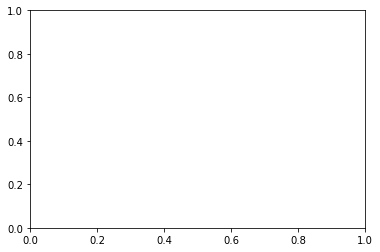

In [23]:
#df['BldgToLotArea']=df['BldgArea']/df['LotArea']
#df['BldgToLotArea']=df['BldgToLotArea'].mask(((df['BldgToLotArea'] < df['BldgToLotArea'].quantile(0.05)) \
#                       | (df['BldgToLotArea'] > df['BldgToLotArea'].quantile(0.95))), np.nan)

fig,ax=plt.subplots()
pp = PdfPages('OtherFiles/growth-continuous.pdf')
props=dict(boxstyle='round',facecolor='white',alpha=0.5)
df_r2=pd.DataFrame()

for count,i in enumerate(df):

    if (df[i].dtype==float or df[i].dtype==int  ) and i!='growth':
        print ('\n\n',count,i,df[i].dtype)
        ax.scatter(df.growth[::50],df[i][::50])
        ax.set_xlabel('growth(in/yr)')
        ax.set_ylabel(i)
        #ax.set_ylim([0,df_well_data[i].max()*1.1])
        #ax.set_xlim([0,800])

        results=stats.linregress(df[['growth',i]].dropna())
        textstr='m={:.3f}\nb={:.3f}\n$r^2$={:.3f}\np={:.3f}'.format(results.slope,results.intercept\
                                                                ,results.rvalue**2,results.pvalue)

        df_r2.at[count,'r2']=results.rvalue**2
        df_r2.at[count,'name']=i
        df_r2.at[count,'pvalue']=results.pvalue
        x=np.array([df.growth.min(),df.growth.max()])
        #x=np.linspace(well_data.As.min(),well_data.As.max())

        ax.plot(x,results.slope*x+results.intercept)

        ax.text(0.7,0.95,textstr,transform=ax.transAxes,fontsize=12\
            ,verticalalignment='top',bbox=props)
        pp.savefig()
        ax.cla()
    elif hasattr(df[i],'cat')==True and i!='problems_15':
        print ('\n\n',count,i,'cat',df.groupby(i)['growth_rate'].mean())
        if df[i].cat.categories.shape[0]>2:
            mod = MultiComparison(df.dropna(subset=[i])['growth_rate'], df.dropna(subset=[i])[i])
            thsd=mod.tukeyhsd()
            print(mod.tukeyhsd())
        else:
            print('we are going to need a t-test')
            samples = [cols[1] for cols in df.groupby(i)['growth_rate']]    #I am not sure how this works but it makes an numpy array for each group     
            print(stats.ttest_ind(samples[0],samples[1]))
            print("\n")
        #pp.attach_note(tt)  # attach metadata (as pdf note) to page
        #pp.savefig(bbox_inches='tight')
        

pp.close()
df_r2.sort_values(by='r2',ascending=False,inplace=True)
df_r2.to_excel('OtherFiles/growth_vs_continuous_data_r2.xlsx')


        #if p_val<0.05:    #If the p value is less than 0.05 it then does the tukey
        #mod = MultiComparison(df.dropna(subset=[col])['growth_rate'], df.dropna(subset=[col])[col])
        #thsd=mod.tukeyhsd()
        #print(mod.tukeyhsd())

## 25-75 Forest Plot
remember to run anova_letters at the end first

spc_common
0       a
1       b
2       c
3     cde
4       f
5      df
6       e
7      gh
8      ce
9       a
10      a
11      i
12      j
13      g
14      h
15      k
dtype: object
0 0 spc_common 00-other
1 1 01-silver linden
2 2 02-pin oak
3 3 03-northern red oak
4 4 04-japanese zelkova
5 5 05-american linden
6 6 06-green ash
7 7 07-silver maple
8 8 08-honeylocust
9 9 09-littleleaf linden
10 10 10-sweetgum
11 11 11-callery pear
12 12 12-london planetree
13 13 13-ginkgo
14 14 14-red maple
15 15 15-norway maple
user_type_15
0    a
1    a
2    b
dtype: object
0 16 user_type_15 NYC Parks Staff
1 17 TreesCount Staff
2 18 Volunteer
health_15
0    a
1    b
2    c
dtype: object
0 19 health_15 Fair
1 20 Good
2 21 Poor
curb_loc_15
0 22 curb_loc_15 OffsetFromCurb
1 23 OnCurb
steward_15
0    a
1    b
2    a
3    a
dtype: object
0 24 steward_15 1or2
1 25 3or4
2 26 4orMore
3 27 None
guards_15
0    a
1    b
2    b
3    b
dtype: object
0 28 guards_15 Harmful
1 29 Helpful
2 30 None
3 31 Unsure
sid

<ipython-input-26-5adbe16aa816>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels,family='monospace')


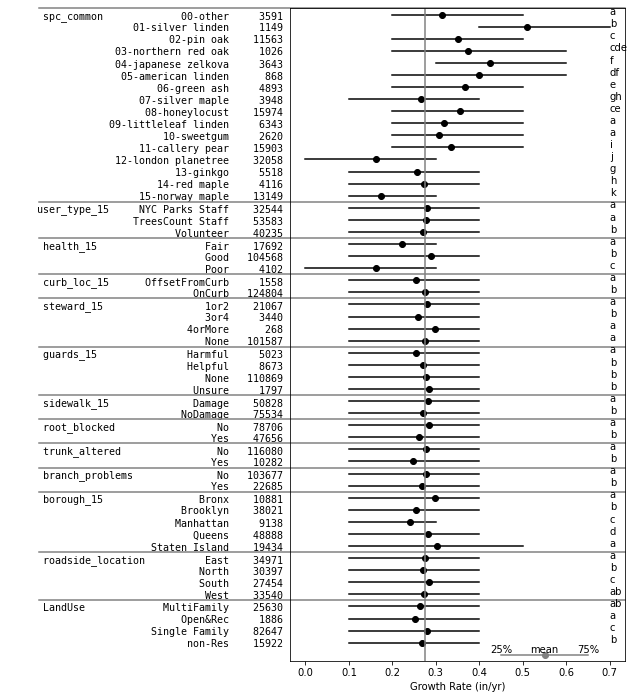

In [26]:
columns=['spc_common','user_type_15','health_15','curb_loc_15','steward_15'\
         ,'guards_15','sidewalk_15','root_blocked','trunk_altered'\
         ,'branch_problems','borough_15','roadside_location','LandUse']
#columns=['spc_common','borough_15','LandUse','steward_15','guards_15','user_type_15','dbh_05']

total=0
labels=[]
edgecolor='k'
facecolor='k'

fig,ax=plt.subplots()
fig.set_size_inches(6,12)

for col in columns:
    print(col)
    if df[col].cat.categories.shape[0]>2:
        df_ltr=anova_letters(df,col_to_group=col,col_for_data='growth_rate')
        print(df_ltr)
    elif df[col].cat.categories.shape[0]==2:
        samples = [cols[1] for cols in df.groupby(col)['growth_rate']]    #I am not sure how this works but it makes an numpy array for each group     
        if stats.ttest_ind(samples[0],samples[1]).pvalue<0.05:
            df_ltr=['a','b']
        else:
            df_ltr=['a','a'] 
    else:
        print("OH CRAP")
        #samples = [cols[1] for cols in df.groupby(col)['growth_rate']]    #I am not sure how this works but it makes an numpy array for each group 
        #f_val, p_val = stats.f_oneway(*samples)  # I am not sure what this star does but this passes all the numpy arrays correctly
        #print('F value: {:.3f}, p value: {:.3f}\n'.format(f_val, p_val))

        # this if statement can be uncommmented if you don't won't to go furhter with out p<0.05
        #if p_val<0.05:    #If the p value is less than 0.05 it then does the tukey
        #mod = MultiComparison(df.dropna(subset=[col])['growth_rate'], df.dropna(subset=[col])[col])
        #thsd=mod.tukeyhsd()
        #print(mod.tukeyhsd())

    for count,cat in enumerate(df[col].cat.categories):
        if count==0:
            print(count,total,col,cat)
            ax.axhline(y=total-0.5,xmin=-.75,xmax=1, color="grey", clip_on=False)
            nm=col
        else:
            print(count,total,cat)
            nm=''

        n=df[df[col]==cat]['growth_rate'].count()
        ax.scatter(df[df[col]==cat]['growth_rate'].mean(),col+cat,edgecolor=edgecolor,facecolor=facecolor)
        #if df[col].cat.categories.shape[0]>2:
        ax.text(0.7,total,df_ltr[count])
        tempy=[col+cat,col+cat]
        tempx=df[df[col]==cat]['growth_rate'].quantile([.25,.75]).values
        #tempx=[]
        ax.plot(tempx,tempy,color=edgecolor)
        #print(row['[0.025'])
        #tempx=[row['[0.025'],row['0.975]']]
        labels.append('{: <17s}{: >14s}{: 9d}'.format(nm,cat,n))
        total+=1
        
ax.set_yticklabels(labels,family='monospace')
ax.axvline(x=df['growth_rate'].mean(),c='grey',ymin=0,ymax=1)
ax.invert_yaxis()
ax.set_xlabel('Growth Rate (in/yr)')
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.tick_params(left=False)
ax.set_ylim(total+0.5,0-.5)

ax.scatter(0.55,total,c='grey')
ax.plot([.45,.65],[total,total],c='grey')
ax.text(.45,total,'25%',rotation=0,horizontalalignment='center',verticalalignment='bottom')
ax.text(.55,total,'mean',rotation=0,horizontalalignment='center',verticalalignment='bottom')
ax.text(.65,total,'75%',rotation=0,horizontalalignment='center',verticalalignment='bottom')
#ax.set_ylim(total,-1)

fig.savefig('Figures/Figure5-growth_rate_data_anova_short.jpg',dpi=600,bbox_inches='tight')

## OLS to Pandas  Ordinary least squares analsysis. 

This link tells you how to get our a nice table to pandas https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe

Notes:
RW_TYPE is all type 1 so taken out
Road direction taken out as have location

For tha analysis the formula contains all the parameters.  If you want to keep something out of the figure put it in control_for.  It will then skip over it during the plot.

-0.3999999999999999
14.6
16.6
19.6


<ipython-input-31-22d1ea023117>:175: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels,family='monospace')


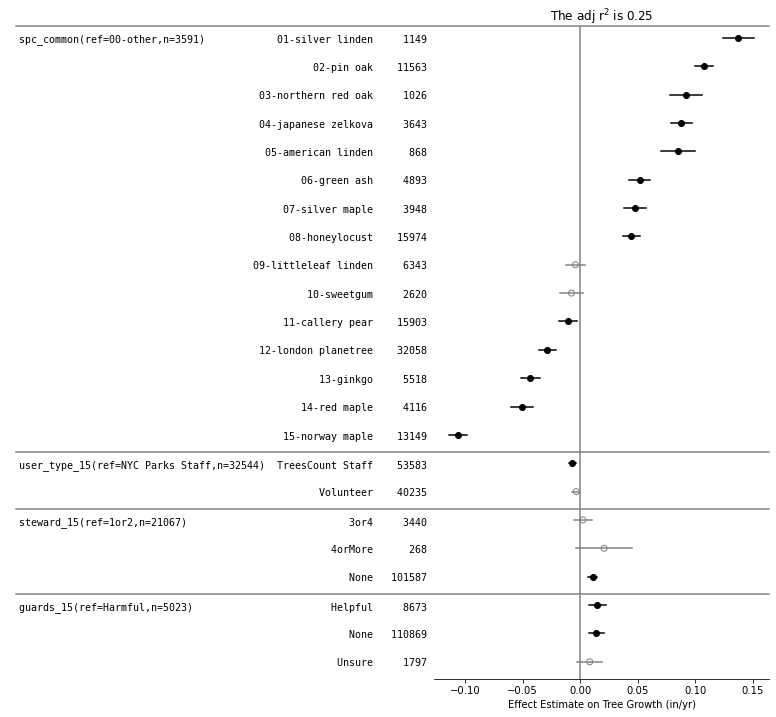

In [31]:
spc='callery pear'


#formula = 'growth ~tree_dbh_05+C(borough_15)+C(steward_15)+C(guards_15)+C(curb_loc_15)'

#formula = 'growth ~tree_dbh_05+C(borough_15)+C(steward_15)+C(guards_15)+C(curb_loc_15)'
#formula='growth ~tree_dbh_05+shadow+C(borough_15)+C(steward_15)+C(guards_15)+C(curb_loc_15)+C(spc_common)'
#C(borough_15)+
## For Paper

##################
##################
### USE BOROUGH for Figure 3
#### True for Figure 3, False for data for Figures 7 and 8
Use_borough=True # True for paper figure False for making maps
control_for_bool=True

if Use_borough==True:
    formula='growth_rate ~C(spc_common)+C(user_type_15)\
            +C(health_15)+C(curb_loc_15)\
            +C(steward_15)+C(guards_15)+C(sidewalk_15)+C(root_blocked)\
            +C(trunk_altered)+C(branch_problems)+C(borough_15)\
            +C(roadside_location)+C(LandUse)\
            +tree_dbh_05+BuiltFAR+pop_density+ST_WIDTH' 
    control_for=['LandUse','trunk_altered','health_15','curb_loc_15'
             ,'sidewalk_15','root_blocked','trunk_altered','branch_problems'
             ,'borough_15','roadside_location','LandUse'
             ,'tree_dbh_05','BuiltFAR','pop_density','ST_WIDTH']
    filename='Figures/Figure7-use_borough_true'
else:
    formula='growth_rate ~C(spc_common)+C(user_type_15)+C(curb_loc_15)\
            +C(steward_15)+C(guards_15)+C(sidewalk_15)+C(root_blocked)\
            +C(trunk_altered)+C(branch_problems)\
            +C(roadside_location)+C(LandUse)\
            +tree_dbh_05+BuiltFAR+pop_density+ST_WIDTH'
    control_for=['LandUse','trunk_altered','health_15','curb_loc_15'
             ,'sidewalk_15','root_blocked','trunk_altered','branch_problems'
             ,'roadside_location','LandUse'
             ,'tree_dbh_05','BuiltFAR','pop_density','ST_WIDTH']
    filename='OtherFiles/For-Figure8-use_borough_false'

 
    
### For model
#formula='growth_rate ~C(spc_common)+C(steward_15)+C(guards_15)\
#            +C(curb_loc_15)+C(LandUse)\
#            +tree_dbh_05+pop_density+ST_WIDTH+BuiltFAR' 


#C(root_blocked)+C(trunk_altered)            +C(branch_problems)+
#+C(roadside_location)
#formula='growth ~tree_dbh_05+C(spc_common)+C(borough_15)+C(LandUse)'#'+C(sidewalk_15)+C(curb_loc_15)' 
#formula='growth ~C(spc_common)+C(borough_15)+C(LandUse)+C(steward_15)+C(guards_15)+C(user_type_15)+tree_dbh_05'

#+C(sidewalk_15)+C(problems_1)+C(root_stone_15)+C(root_grate_15)+C(root_other_15)\
#+C(trunk_wire_15)+C(trnk_light_15)+C(trnk_other_15)+C(brch_light_15)+C(brch_shoe_15)+C(brch_other_15)
# BuiltFAR+LotArea+BldgArea+
#+C(root_grate_15)
#model = ols(formula, df[df.spc_common==spc]).fit()
model = ols(formula, df).fit()
model.summary()

dfR=(model.summary2().tables[1])


#filename='Figures/Figure6-OLS_All_data_no_borough'

if control_for_bool:
    for i, row in dfR.iterrows():

        s=row.name
        #if s[0]=='C':                       #C tells us categorical
        col=s[s.find("(")+1:s.find(")")]  #finds the string in parentheses

        if any([x in s for x in control_for]):
            control_for_bool=True
            dfR.drop(index=(row.name),inplace=True)
            
    filename=filename+'_control_for.pdf'
else:
    filename=filename+'.jpg'


fig,ax=plt.subplots()
fig.set_size_inches(6,12)
#ax.scatter(dfR['Coef.'],dfR.index)
meandiff=df[df.spc_common==spc].growth.mean()-df.growth.mean()

#ax.axvline(x=0,c='grey',ymin=0,ymax=0.96)
#ax.axvline(x=meandiff,ls='--',c='red')
labels=[]
first_cont=True
#count=0
last=''
col=''
change1=.96#1#1.1 #Scrunches.  less than 1 pulls them closer to each other
change2=1.0
change3=-.01#0.0 #shifts up and down

for count,(i, row) in enumerate(dfR.iterrows()):

    s=row.name

    #print(s[0])
    if s!='Intercept':
        sig_check=row['[0.025']*row['0.975]']
        if sig_check<0:
            edgecolor='grey'
            facecolor='none'
        else:
            edgecolor='k'
            facecolor='k'
        tempy=[i,i]
        ax.scatter(row['Coef.'],row.name,edgecolor=edgecolor,facecolor=facecolor)
        #print(row['[0.025'])
        tempx=[row['[0.025'],row['0.975]']]


        
        ax.plot(tempx,tempy,color=edgecolor)
        #labels.append('Intercept')
        if s[0]=='C':                       #C tells us categorical
            col=s[s.find("(")+1:s.find(")")]  #finds the string in parentheses
            cat=s[s.find("[")+1:s.find("]")][2:]  #finds the string in brackets
            n=df[df[col]==cat][col].count()
            if last==col:
                nm=''
            else:
                nm=col
                #print(nm,df[nm].cat.categories[0])
                nmref=df[nm].cat.categories[0]
                #nm=nm+'(ref='+nmref+')'#+'(n=)'+df[col].value_counts()[nmref]+')'
                nm='{}(ref={},n={})'.format(nm,nmref,df[col].value_counts()[nmref])  #This gets the names and numbers
                #print(nmref,df[col].value_counts()[nmref])
                #hlineval=float(i)-0.5
                #print(i,type(i))
                #ax.axhline(y=count-1.5,c='grey')
                #if count>0:
                    #yloc=1-(count*change1)/(len(dfR)*change2)+change3
                    #print('1',yloc,count,len(dfR),ax.collections[0].get_offsets().data)
                    #ax.plot([-1.25,1],[yloc,yloc],transform=ax.transAxes, color="grey", clip_on=False)
                ax.axhline(y=count-1.4,xmin=-1.25,xmax=1, color="grey", clip_on=False)
                print(count-1.4)
            #labels.append('{: <33s}{: >18s}{: 9d}'.format(nm,cat,n))
            #print(col,cat,n)
        else:
            col=s
            n=df[col].count()
            cat=col
            if first_cont==True:
                nm='Normalized Continuous Data'
                first_cont=False
                #ax.axhline(y=count-1.5,c='grey')
                yloc=1-(count*change1)/(len(dfR)*change2)+change3
                #ax.plot([-1.25,1],[yloc,yloc],transform=ax.transAxes, color="grey", clip_on=False)
                ax.axhline(y=count-1.4,xmin=-1.25,xmax=1, color="grey", clip_on=False)
            else:
                nm=''
            #print(s,n)
            #labels.append('{: >18s}{: 9d}'.format(s,n))
        labels.append('{: <41s}{: >18s}{: 9d}'.format(nm,cat,n))
    last=col
    #count+=1
    
#for i in np.arange(len(dfR)):    
#    print(i)
#    ax.axhline(y=i-0.5,xmin=-.75,xmax=1, color="purple", clip_on=False)    
#ax.axhline(y=-.5,xmin=-.75,xmax=1, color="green", clip_on=False)   

#ax.axvline(x=0,c='red',ymin=0,ymax=0.95)

ax.vlines(x=0,colors='grey',ymin=-0.4,ymax=len(dfR))


ax.set_yticklabels(labels,family='monospace')
ax.invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False)

title='The adj r$^2$ is {:0.2f}'.format(model.rsquared_adj)
ax.set_title(title)
ax.set_xlabel('Effect Estimate on Tree Growth (in/yr)')

ax.set_ylim(len(dfR)-1.4,-0.4)

fig.savefig(filename,dpi=600,bbox_inches='tight')

if Use_borough==False:
    df['fitted'] = model.fittedvalues
    df['resid'] = model.resid
    df[['postcode','growth_rate','fitted','resid','ACS_Vulnerability','tree_dbh_05_copy']].to_excel('DataFiles/fitted_growth_rate.xlsx')


In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            growth_rate   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     966.1
Date:                Sun, 21 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:07:27   Log-Likelihood:                 22664.
No. Observations:              126056   AIC:                        -4.524e+04
Df Residuals:                  126011   BIC:                        -4.480e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.2353      0.008     30.597      0.000       0.220       0.250
C(spc_common)[T.01-silver linden]         0.1374      0.007     19.949      0.000       0.124       0.151
C(spc_common)[T.02-pin oak]               0.1074      0.004     27.189      0.000       0.100       0.115
C(spc_common)[T.03-northern red oak]      0.0918      0.007     12.784      0.000       0.078       0.106
C(spc_common)[T.04-japanese zelkova]      0.0879      0.005     18.422      0.000       0.079       0.097
C(spc_common)[T.05-american linden]       0.0851      0.008     11.112      0.000       0.070       0.100
C(spc_common)[T.06-green ash]             0.0516      0.004     11.559      0.000       0.043       0.060
C(spc_common)[T.07-silver maple]          0.0476      0.005      9.914      0.000       0.038       0.057
C(spc_common)[T.08-honeylocust]           0.0445      0.004     11.819      0.000       0.037       0.052
C(spc_common)[T.09-littleleaf linden]    -0.0041      0.004     -0.971      0.332      -0.012       0.004
C(spc_common)[T.10-sweetgum]             -0.0075      0.005     -1.413      0.158      -0.018       0.003
C(spc_common)[T.11-callery pear]         -0.0105      0.004     -2.775      0.006      -0.018      -0.003
C(spc_common)[T.12-london planetree]     -0.0285      0.004     -7.525      0.000      -0.036      -0.021
C(spc_common)[T.13-ginkgo]               -0.0431      0.004     -9.878      0.000      -0.052      -0.035
C(spc_common)[T.14-red maple]            -0.0505      0.005    -10.791      0.000      -0.060      -0.041
C(spc_common)[T.15-norway maple]         -0.1060      0.004    -27.444      0.000      -0.114      -0.098
C(user_type_15)[T.TreesCount Staff]      -0.0068      0.002     -4.407      0.000      -0.010      -0.004
C(user_type_15)[T.Volunteer]             -0.0034      0.002     -1.900      0.057      -0.007       0.000
C(health_15)[T.Good]                      0.0583      0.002     34.545      0.000       0.055       0.062
C(health_15)[T.Poor]                     -0.0433      0.004    -12.258      0.000      -0.050      -0.036
C(curb_loc_15)[T.OnCurb]                 -0.0286      0.005     -5.333      0.000      -0.039      -0.018
C(steward_15)[T.3or4]                     0.0024      0.004      0.609      0.542      -0.005       0.010
C(steward_15)[T.4orMore]                  0.0209      0.012      1.679      0.093      -0.004       0.045
C(steward_15)[T.None]                     0.0108      0.002      5.855      0.000       0.007       0.014
C(guards_15)[T.Helpful]                   0.0150      0.004      4.143      0.000       0.008       0.022
C(guards_15)[T.None]                      0.0142      0.003      4.248      0.000       0.008       0.021
C(guards_

When Use_borough==True rmse of model is 0.2021526880591727
When Use_borough==False rmse of model is 0.20408759206065039

In [33]:
# now generate predictions
ypred = model.predict(df)
df['pred']=ypred

# calc rmse
rmse_model = ((df['growth_rate'] - df['pred']) ** 2).mean() ** .5
print('rmse of model is {}'.format(rmse_model))

rmse of model is 0.2021526880591729


### Stats for Table 3

In [30]:
print('dbh',stats.linregress(df[['growth_rate','tree_dbh_05']].dropna()))
print('\nbuilfat',stats.linregress(df[['growth_rate','BuiltFAR']].dropna()))
print('\npop_dens',stats.linregress(df[['growth_rate','pop_density']].dropna()))
print('\nstreetwidth',stats.linregress(df[['growth_rate','ST_WIDTH']].dropna()))



dbh LinregressResult(slope=-0.7986725405105882, intercept=0.21987670822537028, rvalue=-0.37336259610238903, pvalue=0.0, stderr=0.005582566452632546)

builfat LinregressResult(slope=-0.09777222964458625, intercept=0.026917195824314413, rvalue=-0.04570804787345253, pvalue=2.0557820197552046e-59, stderr=0.006011713360095124)

pop_dens LinregressResult(slope=-0.08139085879511536, intercept=0.022407028650901155, rvalue=-0.038048830174966075, pvalue=1.0457372839136615e-41, stderr=0.006013566311596382)

streetwidth LinregressResult(slope=-0.02332888727984253, intercept=0.006422505697232637, rvalue=-0.010905763597945933, pvalue=0.00010584105113750798, stderr=0.006017378204680333)


### FIGURE ON VOLUNTEERS

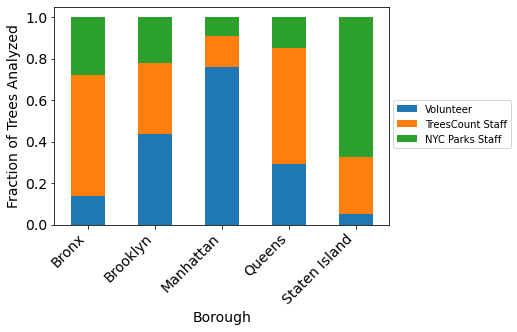

In [34]:
df_gen=df.groupby(['borough_15','user_type_15'])['growth_rate'].count()/df.groupby(['borough_15'])['growth_rate'].count()

df_gen=df_gen.unstack()
df_gen=df_gen[['Volunteer','TreesCount Staff','NYC Parks Staff']]

fig,ax=plt.subplots()
df_gen.plot(kind='bar',stacked=True,ax=ax,fontsize=14)#,color=my_colors)#,colormap='Blues_r')
ax.set_ylabel('Fraction of Trees Analyzed',fontsize=14)
ax.set_xlabel('Borough',fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(loc=[1.01,0.35])

fig.savefig('Figures/Figure6-Tree_measurers_by_borough.jpg',dpi=600,bbox_inches='tight')


In [35]:
df_gen

user_type_15,Volunteer,TreesCount Staff,NYC Parks Staff
borough_15,,,
Bronx,0.136293,0.586527,0.277180
Brooklyn,0.436469,0.343231,0.220299
Manhattan,0.761545,0.149267,0.089188
Queens,0.291053,0.561590,0.147357
Staten Island,0.049861,0.274365,0.675774


## ANOVA LETTERS FUNCTION

In [25]:
def anova_letters(df,col_to_group,col_for_data):
    '''Hans-Peter Piepho (2004) An Algorithm for a Letter-Based Representation of All-Pairwise Comparisons, Journal of Computational and Graphical Statistics, 13:2, 456-466, DOI: 10.1198/1061860043515'''
    #Now take teh data and regroup for anova
    samples = [cols[1] for cols in df.groupby(col_to_group)[col_for_data]]    #I am not sure how this works but it makes an numpy array for each group     
    f_val, p_val = stats.f_oneway(*samples)  # I am not sure what this star does but this passes all the numpy arrays correctly
    #print('F value: {:.3f}, p value: {:.3f}\n'.format(f_val, p_val))
    if len(samples)==2:
        df_ltr=np.array(['a','a'])
        if p_val<0.05:
            df_ltr[1]='b'
        return(df_ltr)
    # this if statement can be uncommmented if you don't won't to go furhter with out p<0.05
    #if p_val<0.05:    #If the p value is less than 0.05 it then does the tukey
    #print(samples)
    mod = MultiComparison(df.dropna(subset=[col_to_group])[col_for_data], df.dropna(subset=[col_to_group])[col_to_group])
    thsd=mod.tukeyhsd()
    #print(mod.tukeyhsd())

    #this is a function to do Piepho method.  AN Alogrithm for a letter based representation of al-pairwise comparisons.  
    tot=len(thsd.groupsunique)
    #make an empty dataframe that is a square matrix of size of the groups. #set first column to 1
    df_ltr=pd.DataFrame(np.nan, index=np.arange(tot),columns=np.arange(tot))
    df_ltr.iloc[:,0]=1
    count=0
    df_nms = pd.DataFrame('', index=np.arange(tot), columns=['names'])  # I make a dummy dataframe to put axis labels into.  sd stands for signifcant difference

    for i in np.arange(tot):   #I loop through and make all pairwise comparisons. 
        for j in np.arange(i+1,tot):
            #print('i=',i,'j=',j,thsd.reject[count])
            if thsd.reject[count]==True:
                for cn in np.arange(tot):
                    if df_ltr.iloc[i,cn]==1 and df_ltr.iloc[j,cn]==1: #If the column contains both i and j shift and duplicat
                        df_ltr=pd.concat([df_ltr.iloc[:,:cn+1],df_ltr.iloc[:,cn+1:].T.shift().T],axis=1)
                        df_ltr.iloc[:,cn+1]=df_ltr.iloc[:,cn]
                        df_ltr.iloc[i,cn]=0
                        df_ltr.iloc[j,cn+1]=0
                    #Now we need to check all columns for abosortpion.
                    for cleft in np.arange(len(df_ltr.columns)-1):
                        for cright in np.arange(cleft+1,len(df_ltr.columns)):
                            if (df_ltr.iloc[:,cleft].isna()).all()==False and (df_ltr.iloc[:,cright].isna()).all()==False: 
                                if (df_ltr.iloc[:,cleft]>=df_ltr.iloc[:,cright]).all()==True:  
                                    df_ltr.iloc[:,cright]=0
                                    df_ltr=pd.concat([df_ltr.iloc[:,:cright],df_ltr.iloc[:,cright:].T.shift(-1).T],axis=1)
                                if (df_ltr.iloc[:,cleft]<=df_ltr.iloc[:,cright]).all()==True:
                                    df_ltr.iloc[:,cleft]=0
                                    df_ltr=pd.concat([df_ltr.iloc[:,:cleft],df_ltr.iloc[:,cleft:].T.shift(-1).T],axis=1)

            count+=1

    #I sort so that the first column becomes A        
    df_ltr=df_ltr.sort_values(by=list(df_ltr.columns),axis=1,ascending=False)

    # I assign letters to each column
    for cn in np.arange(len(df_ltr.columns)):
        df_ltr.iloc[:,cn]=df_ltr.iloc[:,cn].replace(1,chr(97+cn)) 
        df_ltr.iloc[:,cn]=df_ltr.iloc[:,cn].replace(0,'')
        df_ltr.iloc[:,cn]=df_ltr.iloc[:,cn].replace(np.nan,'') 

    #I put all the letters into one string
    df_ltr=df_ltr.astype(str)
    #df_ltr.sum(axis=1)
    #print(df_ltr)
    #print('\n')
    #print(df_ltr.sum(axis=1))
    return(df_ltr.sum(axis=1))
    grps=pd.unique(df[col_to_group].values)   #Finds the group names
    #grps.sort() # This is critical!  Puts the groups in alphabeical order to make it match the plotting



For reference if needed

R - Residence,
C - Commercial,
M -Manufacturing,
P - Park,
B - Battery Park City;